In [1]:
from datetime import datetime 
import pandas as pd
from utils import simulator_period,save_sim_resuls
from subjects.corr_coef import CorrCoeff,TrendFunc
import numpy as np
import matplotlib.pyplot as plt

In [2]:
casino_fig=pd.read_csv('casino_fig.csv', parse_dates = ['Date'])

In [3]:
casino_fig.head()

,Date,Heads,Day_Result,Total_Bets,Total_Hands
0,2022-01-01,27,2226.567576,67021.396083,3398
1,2022-01-02,12,1816.774205,41186.835186,3958
2,2022-01-03,13,-254.078984,35400.768961,1155
3,2022-01-04,10,824.013142,57594.329674,1950
4,2022-01-05,18,1578.764930,29224.280389,1636


In [4]:
casino_fig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097 entries, 0 to 1096
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         1097 non-null   datetime64[ns]
 1   Heads        1097 non-null   int64         
 2   Day_Result   1097 non-null   float64       
 3   Total_Bets   1097 non-null   float64       
 4   Total_Hands  1097 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 43.0 KB


<Axes: xlabel='Date'>

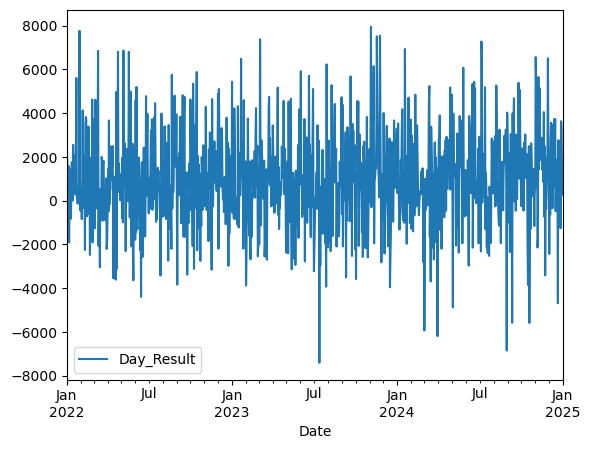

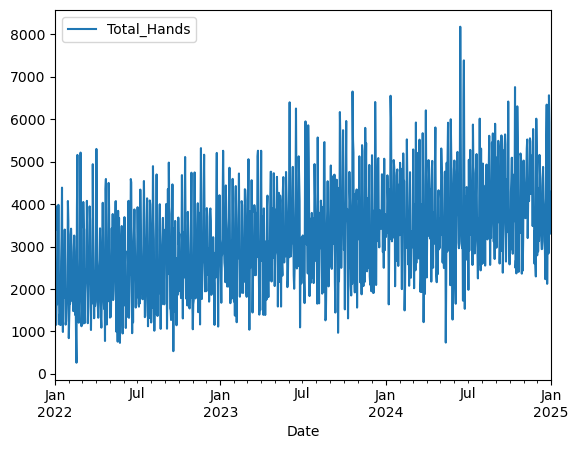

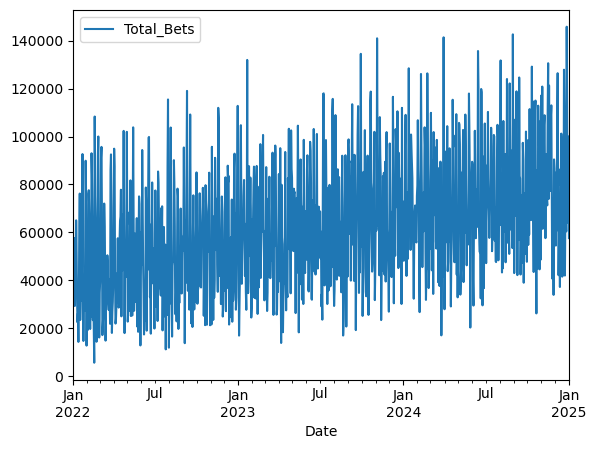

In [5]:
casino_fig[:].plot(x="Date", y ="Day_Result")
casino_fig[:].plot(x="Date", y ="Total_Hands")
casino_fig[:].plot(x="Date", y ="Total_Bets")


In [6]:
casino_fig['Day_Result_roll'] = casino_fig['Day_Result'].rolling(window=7).mean()

<Axes: xlabel='Date'>

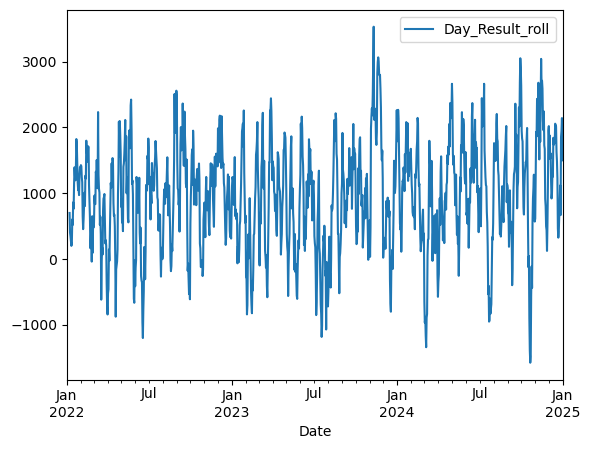

In [7]:
casino_fig.plot(x="Date", y ="Day_Result_roll")

In [8]:
from scipy.signal import medfilt

In [9]:
casino_fig['Day_Result_med'] = medfilt(casino_fig['Day_Result'], kernel_size=49)

<Axes: xlabel='Date'>

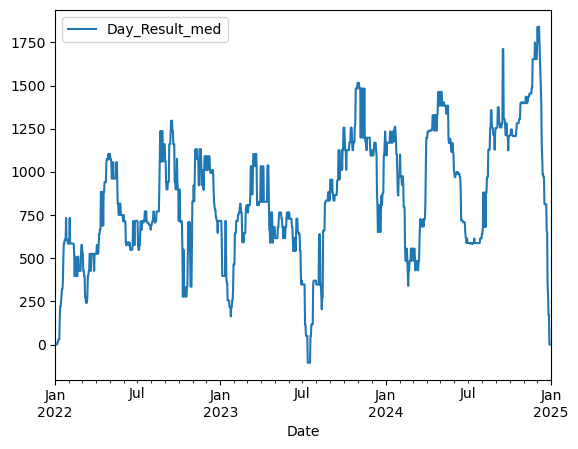

In [10]:
casino_fig.plot(x="Date", y ="Day_Result_med")

In [11]:
casino_fig['Day_Result_ewm'] = casino_fig['Day_Result'].ewm(span=7, adjust=True).mean()


<Axes: xlabel='Date'>

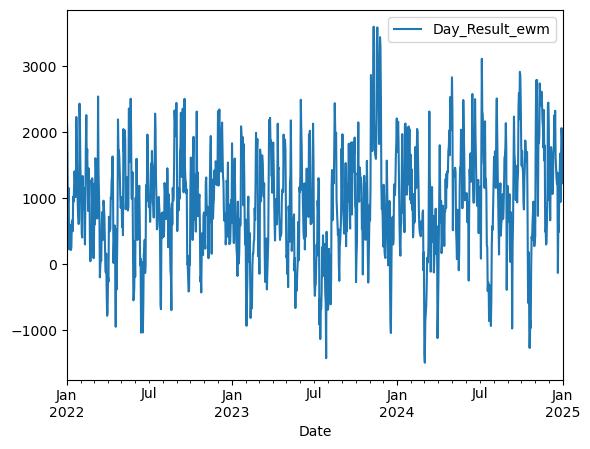

In [12]:
casino_fig.plot(x="Date", y ="Day_Result_ewm")

In [13]:
casino_fig.head()

,Date,Heads,Day_Result,Total_Bets,Total_Hands,Day_Result_roll,Day_Result_med,Day_Result_ewm
0,2022-01-01,27,2226.567576,67021.396083,3398,NaN,0.0,2226.567576
1,2022-01-02,12,1816.774205,41186.835186,3958,NaN,0.0,1992.399935
2,2022-01-03,13,-254.078984,35400.768961,1155,NaN,0.0,1020.949592
3,2022-01-04,10,824.013142,57594.329674,1950,NaN,0.0,948.927119
4,2022-01-05,18,1578.764930,29224.280389,1636,NaN,0.0,1155.378437


In [14]:
casino_fig['Day_Result_ewm_4'] = casino_fig['Day_Result_ewm'].ewm(span=4, adjust=True).mean()

<Axes: xlabel='Date'>

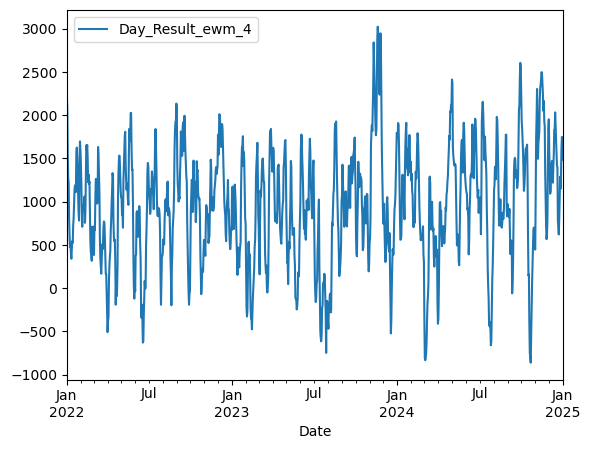

In [15]:
casino_fig.plot(x="Date", y ="Day_Result_ewm_4")

In [16]:
casino_fig['Day_Result_ewm_4_12'] = casino_fig['Day_Result_ewm_4'].ewm(span=72, adjust=True).mean()

<Axes: xlabel='Date'>

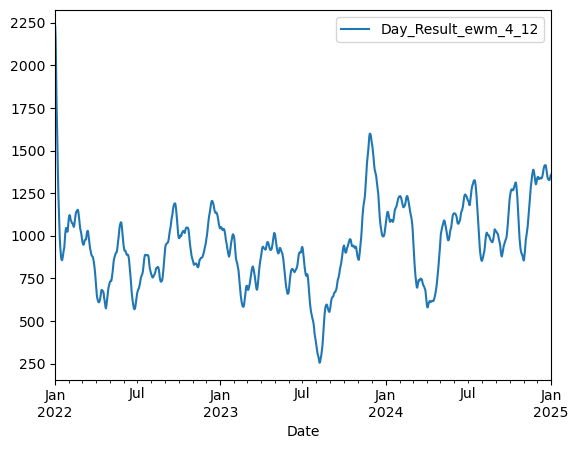

In [17]:
casino_fig.plot(x="Date", y ="Day_Result_ewm_4_12")

In [18]:
casino_fig['Day_Result_ewm'] = casino_fig['Day_Result'].ewm(span=365, adjust=True).mean()

<Axes: xlabel='Date'>

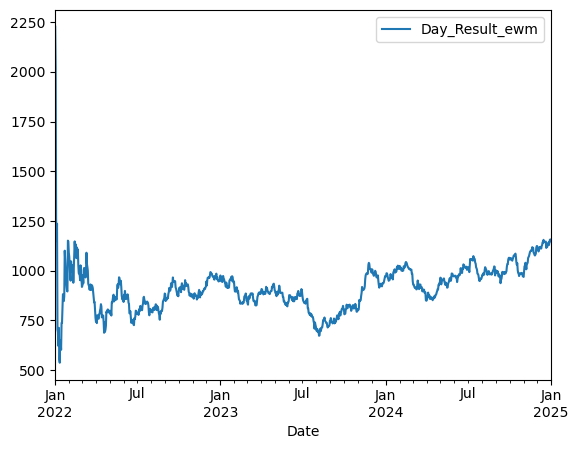

In [19]:
casino_fig.plot(x="Date", y ="Day_Result_ewm")

In [20]:
casino_fig['Total_Bets_ewm'] = casino_fig['Total_Bets'].ewm(span=365, adjust=True).mean()

<Axes: xlabel='Date'>

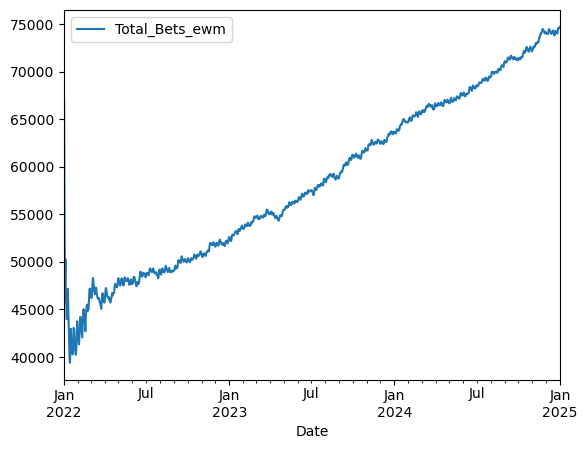

In [21]:
casino_fig.plot(x="Date", y ="Total_Bets_ewm")

In [22]:
from scipy import stats

In [23]:
slope, intercept, r, p, std_err = stats.linregress(casino_fig.index,casino_fig['Total_Bets'])

In [24]:
intercept


np.float64(44894.11594944137)

In [25]:
slope

np.float64(32.56969927745229)

In [26]:
casino_fig['trend_bet']= slope*casino_fig.index+intercept

<Axes: xlabel='Date'>

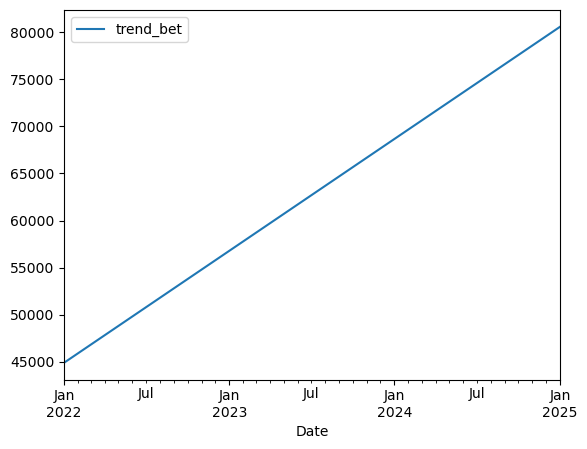

In [27]:
casino_fig.plot(x="Date", y ="trend_bet")

In [28]:
casino_fig['trend_free'] = casino_fig['Total_Bets']-casino_fig['trend_bet'] + intercept

<Axes: xlabel='Date'>

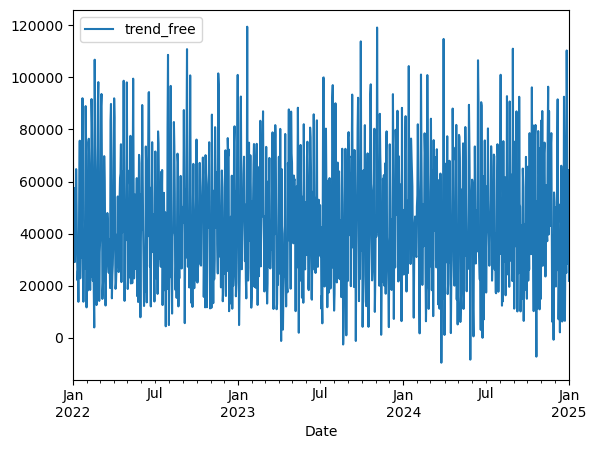

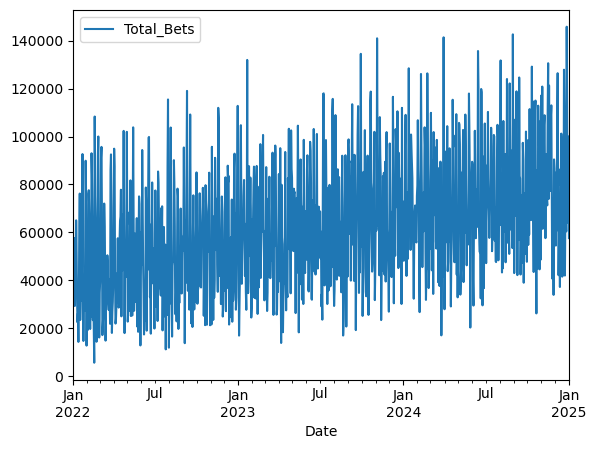

In [29]:
casino_fig.plot(x="Date", y ="trend_free")
casino_fig.plot(x="Date", y ="Total_Bets")

In [30]:
# Perform cubic fit
coefficients = np.polyfit(casino_fig.index,casino_fig['Total_Bets'], 1)
print(coefficients)

[3.25696993e+01 4.48941159e+04]


In [31]:
p = np.poly1d(coefficients)

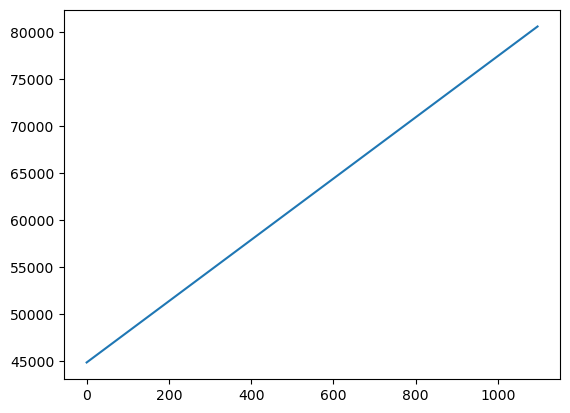

In [32]:
plt.plot(casino_fig.index,p(casino_fig.index))

In [33]:
casino_fig['Date'].iloc[0].weekday() 

5

In [34]:
casino_fig['week_day'] = casino_fig['Date'].dt.dayofweek

In [35]:
casino_fig['week_day']

0       5
1       6
2       0
3       1
4       2
       ..
1092    5
1093    6
1094    0
1095    1
1096    2
Name: week_day, Length: 1097, dtype: int32

In [36]:
casino_fig.groupby('week_day')['trend_free'].mean()

week_day
0    22986.134558
1    32491.577533
2    36272.556281
3    31059.652339
4    65996.981806
5    71544.150356
6    53954.054328
Name: trend_free, dtype: float64

In [37]:
bet_df =casino_fig.groupby('week_day')['trend_free'].agg([ 'mean','std'])

In [38]:
bet_df['low_res'] = bet_df['mean'] - 2* bet_df['std']
bet_df['high_res'] = bet_df['mean'] + 2* bet_df['std']

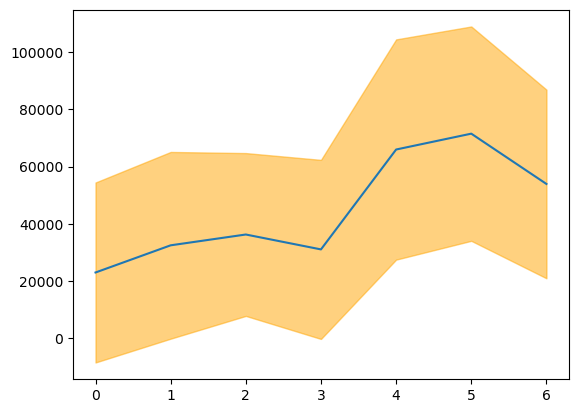

In [39]:
plt.plot(bet_df.index ,bet_df['mean'] )
plt.fill_between(bet_df.index, bet_df['low_res'], bet_df['high_res'], alpha=0.5, color='orange')

In [40]:
bet_df.index

Index([0, 1, 2, 3, 4, 5, 6], dtype='int32', name='week_day')

In [41]:
casino_fig.tail(10)

,Date,Heads,Day_Result,Total_Bets,Total_Hands,Day_Result_roll,Day_Result_med,Day_Result_ewm,Day_Result_ewm_4,Day_Result_ewm_4_12,Total_Bets_ewm,trend_bet,trend_free,week_day
1087,2024-12-23,22,171.572544,41939.168417,2121,416.630655,649.795860,1118.476243,622.071176,1357.068567,74125.812502,80297.379064,6535.905302,0
1088,2024-12-24,21,2702.332584,66876.012816,3748,662.009946,345.329647,1127.153423,789.961251,1341.531381,74086.094370,80329.948763,31440.180002,1
1089,2024-12-25,25,2429.910889,70910.228477,4608,892.973376,291.163128,1134.290498,1029.506749,1332.982761,74068.695587,80362.518463,35441.825964,2
1090,2024-12-26,31,2536.590027,60373.301127,2838,1116.926105,171.572544,1141.972801,1288.010551,1331.750645,73993.667271,80395.088162,24872.328914,3
1091,2024-12-27,26,-1257.422759,145858.128776,6564,666.479709,171.572544,1128.828229,1149.793931,1326.765530,74387.361275,80427.657861,110324.586864,4
1092,2024-12-28,38,3636.671876,108929.773985,5919,1855.442903,0.000000,1142.566721,1336.284246,1327.026317,74576.591846,80460.227560,73363.662374,5
1093,2024-12-29,31,3395.894637,64124.764320,3297,1945.078543,0.000000,1154.910754,1626.165927,1335.221922,74519.335332,80492.797260,28526.083009,6
1094,2024-12-30,22,1551.900869,85592.305091,3668,2142.268303,0.000000,1157.085490,1749.186178,1346.563409,74579.993718,80525.366959,49961.054081,0
1095,2024-12-31,32,345.329647,100031.252771,4291,1805.553598,0.000000,1152.638703,1664.159638,1355.264675,74719.415335,80557.936658,64367.432062,1
1096,2025-01-01,27,291.163128,57579.149318,3475,1500.018204,0.000000,1147.919617,1488.598044,1358.917644,74625.522482,80590.506358,21882.758910,2


In [53]:
# casino_fig['Total_Bets'][1080:1080+7]
# casino_fig['week_day'][1080:1080+7]

1080    0
1081    1
1082    2
1083    3
1084    4
1085    5
1086    6
Name: week_day, dtype: int32

In [42]:
casino_fig['Total_Bets'][1087:1094]

1087     41939.168417
1088     66876.012816
1089     70910.228477
1090     60373.301127
1091    145858.128776
1092    108929.773985
1093     64124.764320
Name: Total_Bets, dtype: float64

In [43]:
casino_fig['week_day'][1087:1094]

1087    0
1088    1
1089    2
1090    3
1091    4
1092    5
1093    6
Name: week_day, dtype: int32

In [44]:
bet_df['mean']  = casino_fig.index[1087:1094]*slope + bet_df['mean']

In [45]:
bet_df['low_res'] = bet_df['mean'] - 3* bet_df['std']
bet_df['high_res'] = bet_df['mean'] + 3* bet_df['std']

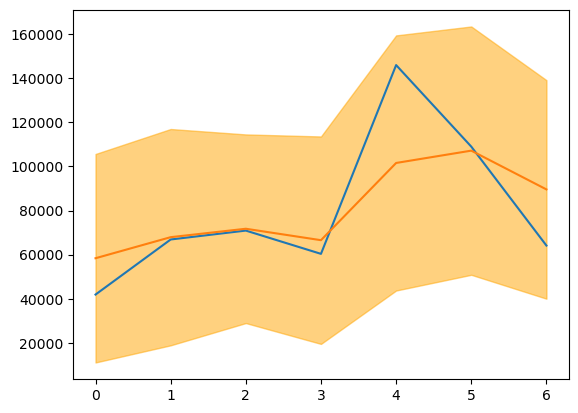

In [56]:
plt.plot(bet_df.index ,casino_fig['Total_Bets'][1087:1094] )
plt.plot(bet_df.index ,bet_df['mean'] )
plt.fill_between(bet_df.index, bet_df['low_res'], bet_df['high_res'], alpha=0.5, color='orange')

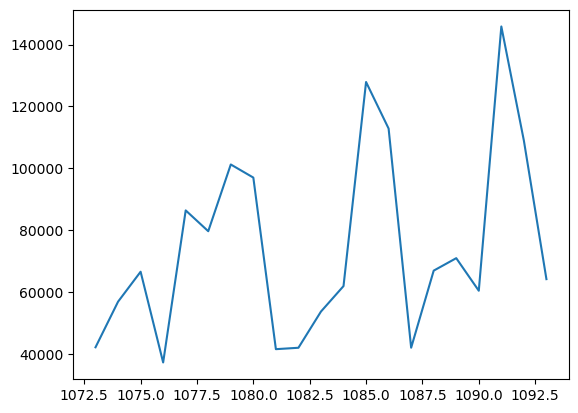

In [55]:
plt.plot(casino_fig['Total_Bets'][1073:1094] )